In [2]:

import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import time

In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 5
LEARNING_RATE = 0.01
NUM_WORKERS = 10 

In [4]:
train_dataset = datasets.MNIST(root = '../data', 
                                 train = True, 
                                 transform = transforms.ToTensor(), 
                                 download = True)

train_dataloader = DataLoader(train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS, 
                              drop_last = True)

test_dataset = datasets.MNIST(root = '../data', 
                                train = False, 
                                transform = transforms.ToTensor(), 
                                download = True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = NUM_WORKERS, 
                             drop_last = True)

In [5]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


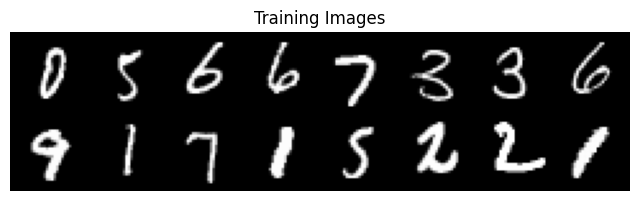

In [6]:
for images, labels in train_dataloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

plt.figure(figsize = (8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:16], padding =2 , normalize = True), (1, 2, 0)))
plt.show()

In [14]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_path = "../data"):
        super(DataModule, self).__init__()
        
        self.data_path = data_path
        
    def prepare_data(self):
        
        datasets.CIFAR10(root = self.data_path, 
                         download = True)
        
        self.train_transform = transforms.Compose([
           torchvision.transforms.ToTensor(),
           torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        
        self.test_transform = transforms.Compose([
              torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]) 
        return          
       
    def setup(self, stage = None):
        train = datasets.CIFAR10(root = '../data', 
                                 train = True, 
                                 transform = self.train_transform, 
                                 download = False)
        
        self.test = datasets.CIFAR10(root = '../data', 
                                    train = False, 
                                    transform = self.test_transform, 
                                    download = False)
        
        self.train_dataset, self.val_dataset = random_split(train, [45000, 5000])
        
    
    def train_dataloader(self):
        train_dataloader = DataLoader(self.train_dataset, 
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS, 
                            drop_last = True, 
                            persistent_workers = True)
        
        return train_dataloader

    def val_dataloader(self):
        valid_dataloader = DataLoader(self.val_dataset, 
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False, 
                                    num_workers = NUM_WORKERS, 
                                    drop_last = True, 
                                    persistent_workers = True)
        
        return valid_dataloader
    
    def test_dataloader(self):
        test_dataloader = DataLoader(self.test, 
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False, 
                                    num_workers = NUM_WORKERS, 
                                    drop_last = True, 
                                    persistent_workers = True)
        
        return test_dataloader
        

In [17]:
class PyTorchVGG16(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.features = nn.Sequential(
            self.block_1, self.block_2, 
            self.block_3, self.block_4, 
            self.block_5
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
             
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
    def forward(self, x):

        x = self.features(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)

        return logits

In [18]:
class LightningModel(pl.LightningModule):
    
    def __init__(self, model, learning_rate):
        super(LightningModel, self).__init__()
        
        self.model = model
        self.learning_rate = learning_rate
        
        self.save_hyperparameters(ignore = ['model'])
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)

    def forward(self, x):
        return self.model(x)
    
    
    def shared_step(self, batch):
        features, labels = batch
        logits = self.model(features)
        loss = torch.nn.functional.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim = 1)
        
        return loss, labels, preds
    
    def training_step(self, batch, batch_idx):
        
        loss, labels, preds = self.shared_step(batch)
        self.log("train_loss", loss)
        
        # Same as above but in eval mode to account for dropout layers
        self.model.eval()
        with torch.inference_mode():
            _, labels, preds = self.shared_step(batch)
            self.train_acc(preds, labels)
            self.log("train_acc", self.train_acc, on_epoch = True, on_step=False)
            self.model.train()
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        
        loss, labels, preds = self.shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(preds, labels)
        self.log("valid_acc", self.valid_acc, on_epoch = True, on_step=False, prog_bar = True)
    
    def test_step(self, batch, batch_idx):
        
        loss, labels, preds = self.shared_step(batch)
        self.log("test_loss", loss)
        self.test_acc(preds, labels)
        self.log("test_acc", self.test_acc, on_epoch = True, on_step=False)

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)
        
        return optimizer

In [19]:
torch.manual_seed(42)

data_module = DataModule(data_path='../data')

pytorch_model = PyTorchVGG16(num_classes = 10)

lightning_model = LightningModel(pytorch_model, learning_rate = LEARNING_RATE)

callbacks = [ModelCheckpoint(monitor='valid_acc', save_top_k=1, mode='max')]
logger = CSVLogger("logs", name = "mnist_logs")

In [25]:
import time 

start = time.time()

trainer = pl.Trainer(max_epochs = NUM_EPOCHS,
                     callbacks = callbacks,
                        logger = logger,
                        devices = 1, 
                        accelerator = "mps", 
                        log_every_n_steps = 100)

trainer.fit(model = lightning_model, datamodule = data_module)

runtime = (time.time() - start)/60
print(f"Runtime: {runtime} minutes")

MisconfigurationException: `MPSAccelerator` can not run on your system since the accelerator is not available. The following accelerator(s) is available and can be passed into `accelerator` argument of `Trainer`: ['cpu'].

In [24]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps
